In [8]:
%load_ext autoreload
%autoreload 2

train_path = "Dataset/Train"
test_path = "Dataset/Test"
val_path = "Dataset/Val" 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os 

import torch
from torchvision import transforms
import numpy as np

from models.pca import PCA_Net
from models.vae import VariationalAutoencoderMixto
from models.hybrid import HybridGNet

from dataLoader import LandmarksDataset, ToTensor, Rescale
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse

In [22]:
vae = VariationalAutoencoderMixto(inputsize = 332, latents = 64).to(device)
vae.load_state_dict(torch.load("weightsExp2/vae2.pt"))
vae.eval()

print('Vae Loaded')

pca = PCA_Net(latents = 128).to(device)
pca.load_state_dict(torch.load("weightsExp2/pca2.pt"))
pca.eval()

print('PCA Loaded')

Vae Loaded
PCA Loaded


In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

A = np.load('adjacencyMatrix.npy')
A = sp.csc_matrix(A).tocoo()

I = np.eye(166)
I = sp.csc_matrix(I).tocoo()

D = [I.copy(), I.copy(), I.copy(), I.copy()]
U = [I.copy(), I.copy(), I.copy(), I.copy()]
A = [A.copy(), A.copy(), A.copy(), A.copy()]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to('cuda:0') for x in X] for X in (A, D, U))

num_nodes = [166, 166, 166, 166]
num_features = 2

config = {}

config['n_layers'] = 4
config['num_conv_filters'] = [16, 16, 16, 16, 16]
config['polygon_order'] = [6, 6, 6, 6, 6]
config['kld_weight'] = 1e-5
config['z'] = 64

hybrid = HybridGNet(config, num_features, D_t, U_t, A_t, num_nodes).to(device)
hybrid.load_state_dict(torch.load("weightsExp2/hybrid2.pt"))
hybrid = hybrid.eval()

In [24]:
from dataLoader import LandmarksDataset, Rescale, ToTensor
from torchvision import transforms
import os

img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'landmarks')
test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(512),
                                             ToTensor()])
                                 )

torch.manual_seed(420)

sample = test_dataset[0]
image, target, seg = sample['image'].to(device), sample['landmarks'].to(device), sample['seg'].to(device).float()

In [30]:
import pandas as pd
from sklearn.metrics import mean_squared_error

model_list = [hybrid, vae, pca]
model_names = ['HybridGNet', 'VAE', 'PCA']

results1 = pd.DataFrame()

for i in range(0, len(test_dataset.images)):    
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['seg'].float(), sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1).numpy()
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
            output = output.cpu().numpy().reshape(-1) 
            error = mean_squared_error(target * 512, output * 512)
            aux = pd.DataFrame([[i, error, model_names[j]]], columns=['i','MSE', 'Model'])
            results1 = results1.append(aux, ignore_index = True)

In [31]:
pred = np.load('weightsExp2/resultsMultiAtlas2.npy')
pred.shape

model_names.append('MultiAtlas')

for i in range(0, 51):
    sample = test_dataset[i]

    target = sample['landmarks']
    target =  target.reshape(-1).numpy()
    output = pred[i, :]
    
    error = mean_squared_error(target * 512, output)
    aux = pd.DataFrame([[i, error, 'MultiAtlas']], columns=['i','MSE', 'Model'])
    results1 = results1.append(aux, ignore_index = True)

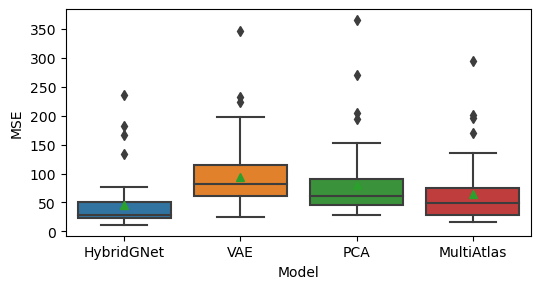

In [34]:
import seaborn as sns
import matplotlib.ticker as mticker

plt.figure(figsize = (6, 3), dpi=100)

ax = plt.subplot(111)

sns.boxplot(x = 'Model', y = 'MSE', data = results1, showmeans = True)

plt.show()

In [37]:
from medpy.metric import dc, hd, assd, jc
from utils.fun import reverseVector, drawBinary

def evalImageMetrics(blank, output, target):
    p1, p2, h, c1, c2 = reverseVector(target)
       
    pgt = drawBinary(blank.copy(), p1)
    pgt = drawBinary(pgt, p2)
    
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)

    hdp = hd(ptest, pgt, voxelspacing = 0.7)

    p1, p2, h, c1, c2 = reverseVector(target)

    pgt = drawBinary(blank.copy(), h)

    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), h)
    
    hdc = hd(ptest, pgt, voxelspacing = 0.7)
    
    p1, p2, h, c1, c2 = reverseVector(target)
       
    pgt = drawBinary(blank.copy(), c1)
    pgt = drawBinary(pgt, c2)
    
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), c1)
    ptest = drawBinary(ptest, c2)

    hdcla = hd(ptest, pgt, voxelspacing = 0.7)
    
    return [hdp, hdc, hdcla]

In [38]:
blank = np.zeros([512, 512])
model_names = ['HybridGNet', 'VAE', 'PCA']
results = pd.DataFrame()

for i in range(0, len(test_dataset.images)):
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['seg'], sample['landmarks']
        data = torch.unsqueeze(data, 0).float().to(device)
        target =  target.reshape(-1).numpy()
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
                
            output = output.cpu().numpy().reshape(-1) 
            
            metrics = evalImageMetrics(blank, output * 512, target * 512)
            
            aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','HD Pulmon','HD Corazon', 'HD Clavicula'])
            results = results.append(aux, ignore_index = True)

In [39]:
pred = np.load('weightsExp2/resultsMultiAtlas2.npy')

for i in range(0, 51):
    sample = test_dataset[i]

    target = sample['landmarks']
    target =  target.reshape(-1).numpy()
    output = pred[i, :]
    
    metrics = evalImageMetrics(blank, output, target * 512)
             
    aux = pd.DataFrame([[i,'MultiAtlas'] + metrics], columns=['i','Model','HD Pulmon','HD Corazon','HD Clavicula'])
    results = results.append(aux, ignore_index = True)

In [40]:
results['HD Promedio'] = results[['HD Pulmon', 'HD Corazon', 'HD Clavicula']].mean(axis=1)

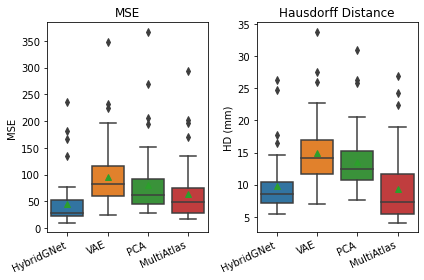

In [43]:
import matplotlib.ticker as mticker

plt.figure(figsize = (6,4))

ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'MSE', data = results1, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('MSE')
plt.title('MSE')
plt.xlabel(None)

#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
#ax.yaxis.set_ticks([25, 50, 100, 200, 400])

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Promedio', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
#ax.yaxis.set_ticks([10, 20, 30, 40, 50])

plt.tight_layout()